<a href="https://colab.research.google.com/github/Mechtanium/DeepLearning/blob/main/Music_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
import pprint as pp
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

In [ ]:
# Download the dataset
songs = mdl.lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

In [ ]:
# Convert the ABC notation to audio file and listen to it
mdl.lab1.play_song(example_song)

In [ ]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

In [ ]:
### Define numerical representation of text ###

# Create a dictionary mapping from character to unique index.
# For example, to get the index of the character "d",
#   we can evaluate `char2idx["d"]`.
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a array mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)
print(enumerate(vocab))
pp.pprint(char2idx)
print(idx2char)

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

In [ ]:
### Vectorize the songs string ###

'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

  NOTE: the output of the `vectorize_string` function
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''

def vectorize_string(string):
    return np.array([char2idx[c] for c in string])

vectorized_songs = vectorize_string(songs_joined)
print(vectorized_songs)

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n - seq_length, batch_size)

  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = [vectorized_songs[i : i + seq_length] for i in idx]
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[i + 1 : i + seq_length + 1] for i in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])

  # [DEBUG] See the reason for "reshape". Slicing operation {lines #11 & #13}
  # returns array([a, b]) object not [a, b]
#   print(f"{input_batch} in {x_batch} \n{output_batch} out {y_batch}")

  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args):
   print("======\n[FAIL] could not pass tests")
else:
   print("======\n[PASS] passed all tests!")

In [ ]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

# [DEBUG] See outputs of "get_batch"
print(x_batch, '\n', y_batch)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

In [ ]:
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
    rnn_units,
    return_sequences=True,
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [ ]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units.
    # TODO: Call the LSTM function defined above to add this layer.
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size.
    # TODO: Add the Dense layer.
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

# Build a simple model with default hyperparameters. You will get the
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [ ]:
model.summary()

In [ ]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

In [ ]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print(len(sampled_indices))
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

In [ ]:
### Defining the loss function ###

'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) # TODO
  return loss

'''TODO: compute the loss using the true next characters from the example batch
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred) # TODO

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

In [ ]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 12000  # Increase this to train longer
batch_size = 64  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 1e-5  # Experiment between 1e-5 and 1e-1

# Model parameters:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

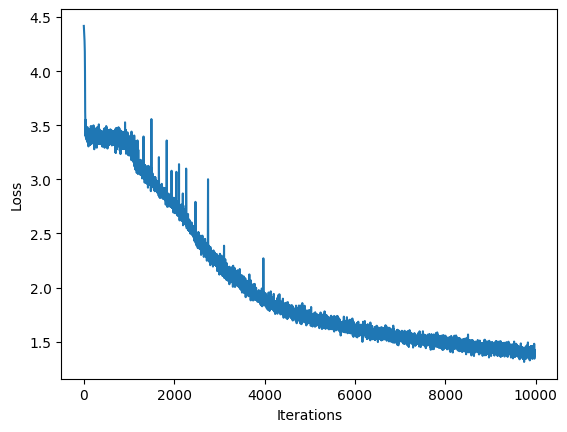

100%|██████████| 10000/10000 [14:21<00:00, 11.60it/s]


1.4038007


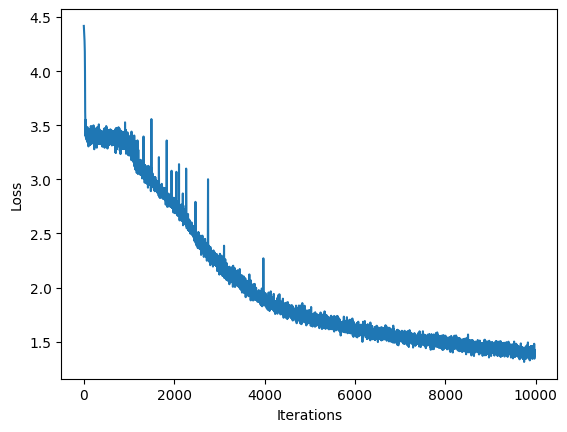

In [ ]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate)

@tf.function
def train_step(x, y):
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:

    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)

    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients
  '''TODO: complete the function call for gradient computation.
      Remember that we want the gradient of the loss with respect all
      of the model parameters.
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)
print(np.mean(history[-500:]))


In [ ]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

In [ ]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [x for x in vectorize_string(start_string)]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)

      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)

      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [ ]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string="X", generation_length=1000)

In [ ]:
### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it!
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)